# Experimental validation plots

36
(24, 32) 32


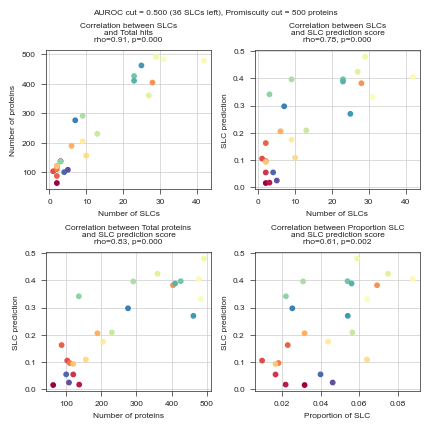

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import joblib
import stylia

data = pd.read_csv("../results/1_experimental_validation_predictions_groups.tsv", sep="\t")
metadata = joblib.load("../results/1_experimental_validation_predictions_groups.metadata")

MIN_AUROC = 0.5
MAX_NUM_PROTEINS = 500
MIN_NUM_PROTEINS = 50

data = data[data["num_prot"] < MAX_NUM_PROTEINS]
data = data[data["num_prot"] > MIN_NUM_PROTEINS]

slc_columns = list([x for x in data.columns if x.startswith("clu") or x.startswith("prot")])
print(len(slc_columns))

aurocs = []
X = np.array(data[slc_columns])
idxs = []
for j in range(X.shape[1]):
    auroc = metadata[j]["auroc"]
    if auroc is None:
        continue
    if auroc[0] > MIN_AUROC:
        idxs += [j]
        aurocs += [auroc[0]]

weights = np.clip(aurocs, 0.5, 1) - 0.5
weights = weights / np.sum(weights)

X = X[:,idxs]
print(X.shape, len(weights))

y_stat = np.average(X, axis=1, weights=weights)

fig, axs = stylia.create_figure(2, 2, height=stylia.TWO_COLUMNS_WIDTH*0.6, width=stylia.TWO_COLUMNS_WIDTH*0.6)

def correlation_label(x,y):
    rho, pval = spearmanr(x,y)
    return "\nrho={0:.2f}, p={1:.3f}".format(rho, pval)

ax = axs.next()
x = data["num_slc"]
y = data["num_prot"]
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between SLCs\nand Total hits"+correlation_label(x,y), xlabel="Number of SLCs", ylabel="Number of proteins")

ax = axs.next()
x = data["num_slc"]
y = y_stat
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between SLCs\nand SLC prediction score"+correlation_label(x,y), xlabel="Number of SLCs", ylabel="SLC prediction")

ax = axs.next()
x = data["num_prot"]
y = y_stat
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between Total proteins\nand SLC prediction score"+correlation_label(x,y), xlabel="Number of proteins", ylabel="SLC prediction")

ax = axs.next()
x = data["num_slc"]/data["num_prot"]
y = y_stat
ax.scatter(x=x, y=y, c=[i for i in range(len(data))], cmap="Spectral")
stylia.label(ax, title="Correlation between Proportion SLC\nand SLC prediction score"+correlation_label(x,y), xlabel="Proportion of SLC", ylabel="SLC prediction")

plt.tight_layout()
plt.suptitle("AUROC cut = {0:.3f} ({1} SLCs left), Promiscuity cut = {2} proteins".format(MIN_AUROC, len(slc_columns), MAX_NUM_PROTEINS))

stylia.save_figure("../assets/1_prospective_validation_groups_{0}_{1}.png".format(MIN_AUROC, MAX_NUM_PROTEINS))
